# Implementación del algoritmo KNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import warnings
import cv2
from collections import Counter

style.use('fivethirtyeight')

## Lectura de las imágenes

In [2]:
import os
from PIL import Image

DIR_NAME = "images"
train_dir_path = os.path.join(os.path.curdir,DIR_NAME,"train")
test_dir_path = os.path.join(os.path.curdir,DIR_NAME,"test")

# Armar una lista de los archivos en cada directorio
train_image_files = [f for f in os.listdir(train_dir_path) if os.path.isfile(os.path.join(train_dir_path, f))]
test_image_files = [f for f in os.listdir(test_dir_path) if os.path.isfile(os.path.join(test_dir_path, f))]

# Leer cada archivo y colocar los labels
dataset = {'arandela': [], 'tornillo': [], 'tuerca': [], 'clavo': []}
test_dataset = {'arandela': [], 'tornillo': [], 'tuerca': [], 'clavo': []}

def load_images(image_files, directory_path, dataset):
    """Carga las imágenes contenidas en la lista images_files y las coloca en el diccionario dataset"""
    for f in image_files:
        label = f.split("_")[0]
        if label in dataset.keys():
            image = Image.open(os.path.join(directory_path, f))
            image_array = np.array(image)
            dataset[label].append(image_array)
        else:
            raise Exception(f"""El archivo {f} no pudo ser asignado a ninguna clase. 
                            El nombre del mismo debe comenzar por uno de los siguientes: ['arandela', 'tuerca', 'tornillo', 'clavo'], seguido de un guión bajo.
                             Revisa el nombre del mismo""")

load_images(train_image_files, train_dir_path, dataset)
load_images(test_image_files, test_dir_path, test_dataset)

## Guardar imagenes

In [3]:
def save_images(dataset, output_directory):
    # Crea la carpeta si no existe
    os.makedirs(output_directory, exist_ok=True)

    for label, images in dataset.items():
        # Crea una subcarpeta para cada label
        label_dir = os.path.join(output_directory, label)
        os.makedirs(label_dir, exist_ok=True)

        for idx, image in enumerate(images):
            output_path = os.path.join(label_dir, f"{label}_{idx}.jpg")
            cv2.imwrite(output_path, image)
    print(f"Images saved successfully in '{output_directory}'!")

## Transformación de las imágenes

### Recortar las imagenes

In [4]:
def resize_images(dataset, new_height):
    resized_dataset = {label: [] for label in dataset.keys()}

    for label, images in dataset.items():
        print(f"Resizing images for label: {label}")
        for image in images:
            height, width, _ = image.shape  # Correct order is height, width, channels
            ratio = width / height  # Aspect ratio: width divided by height
            new_width = int(ratio * new_height)  # Calculate the new width maintaining aspect ratio
            resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
            resized_dataset[label].append(resized_image)

    return resized_dataset

In [5]:
dataset = resize_images(dataset, new_height=2048)

Resizing images for label: arandela
Resizing images for label: tornillo
Resizing images for label: tuerca
Resizing images for label: clavo


### Convertir a Escala de Grises

In [6]:
gs_dataset = {'arandela': [], 'tornillo': [], 'tuerca': [], 'clavo': []}
output_dir = os.path.join(os.path.curdir,DIR_NAME,"grayscale")


for label, images in dataset.items():
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gs_dataset[label].append(gray_image)
save_images(gs_dataset, output_dir)

Images saved successfully in '.\images\grayscale'!


### Convertir a Blanco y Negro

#### Simple Thresholding
For every pixel, the same threshold value is applied. If the pixel value is smaller than or equal to the threshold, it is set to 0, otherwise it is set to a maximum value.

In [7]:
bw_simple_dataset = {'arandela': [], 'tornillo': [], 'tuerca': [], 'clavo': []}
output_dir = os.path.join(os.path.curdir,DIR_NAME,"black_white", "simple")

for label, images in gs_dataset.items():
    for image in images:
        _, bw_image = cv2.threshold(image,75,255,cv2.THRESH_BINARY)
        bw_simple_dataset[label].append(bw_image)

save_images(bw_simple_dataset, output_dir)

Images saved successfully in '.\images\black_white\simple'!


#### Otsu's Thresholding
Otsu's method avoids having to choose a value and determines it automatically.

In [8]:
otsu_dataset = {'arandela': [], 'tornillo': [], 'tuerca': [], 'clavo': []}
output_dir = os.path.join(os.path.curdir,DIR_NAME,"black_white", "otsu")

for label, images in gs_dataset.items():
    for image in images:
        _, bw_image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        otsu_dataset[label].append(bw_image)

save_images(otsu_dataset, output_dir)

Images saved successfully in '.\images\black_white\otsu'!


#### Filter + Otsu

In [9]:
otsu_filtered_dataset = {'arandela': [], 'tornillo': [], 'tuerca': [], 'clavo': []}
output_dir = os.path.join(os.path.curdir,DIR_NAME,"black_white", "otsu_filtered")

for label, images in gs_dataset.items():
    for image in images:
        blur = cv2.GaussianBlur(image,(15,15),0)
        _, bw_image = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        otsu_filtered_dataset[label].append(bw_image)

save_images(otsu_filtered_dataset, output_dir)

Images saved successfully in '.\images\black_white\otsu_filtered'!


## Deteccion de los contornos

In [20]:
def find_and_filter_contours(image, min_length):
    """
    Finds and filters contours based on a minimum length.

    Parameters:
        image (numpy.ndarray): Binary image.
        min_length (float): Minimum contour length to retain.

    Returns:
        list: Filtered contours.
    """
    if np.mean(image) > 127:  # Invert for white background
        image = cv2.bitwise_not(image)
        print(f"Inverting colors.")
    
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cnt for cnt in contours if cv2.arcLength(cnt, closed=True) >= min_length]

In [21]:
def get_main_contour(filtered_contours, image_center, length_weight=0.7):
    """
    Identifies the main contour closest to the center of the image, prioritizing longer contours.

    Parameters:
        filtered_contours (list): List of filtered contours.
        image_center (tuple): Coordinates of the image center (cx, cy).
        length_weight (float): Weight to prioritize longer contours (0 to 1).

    Returns:
        numpy.ndarray: Main contour balancing length and proximity to the image center.
    """

    main_contour = None
    best_score = float('-inf')  # Start with the lowest possible score

    for contour in filtered_contours:
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            distance = np.linalg.norm(np.array([cx, cy]) - image_center)

            # Normalize distance and compute the perimeter (arc length)
            perimeter = cv2.arcLength(contour, closed=True)
            distance_score = 1 / (1 + distance)  # Higher score for smaller distances

            # Combine the scores with a weighted approach
            score = length_weight * perimeter + (1 - length_weight) * distance_score

            # Update the main contour if the score is better
            if score > best_score:
                best_score = score
                main_contour = contour

    return main_contour

In [22]:
def convex_Hull(contours):
    all_points = np.vstack(contours)

    return cv2.convexHull(all_points)

In [23]:
def approximate_contour(contour, epsilon_factor):
    """
    Approximates a contour using the Douglas-Peucker algorithm.

    Parameters:
        contour (numpy.ndarray): Original contour.
        epsilon_factor (float): Factor to determine approximation accuracy.

    Returns:
        numpy.ndarray: Approximated contour.
    """
    epsilon = epsilon_factor * cv2.arcLength(contour, closed=True)
    return cv2.approxPolyDP(contour, epsilon, closed=True)

In [24]:
def crop_and_adjust_contours(image, main_contour, filtered_contours):
    """
    Crops the image around the bounding box of the contour and adjusts all contours
    relative to the cropped region.

    Parameters:
        image (numpy.ndarray): Original image.
        contour (numpy.ndarray): Main contour.
        filtered_contours (list): List of filtered contours.

    Returns:
        tuple: Cropped image and adjusted contours.
    """
    x, y, w, h = cv2.boundingRect(main_contour)
    cropped_image = image[y:y+h, x:x+w]
    adjusted_contours = [cnt - np.array([x, y]) for cnt in filtered_contours]
    adjusted_main_contour = main_contour - np.array([x, y])

    image_with_contours = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(image_with_contours, (0, 0), (w,h), (0, 0, 255), 5)

    cv2.drawContours(image_with_contours, adjusted_contours, -1, (0, 255, 0), 5)
    cv2.drawContours(image_with_contours, [adjusted_main_contour], -1, (255, 0, 0), 5)
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return cropped_image, adjusted_contours, adjusted_main_contour

In [25]:
otsu_filtered_dataset['arandela'][0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]],
      shape=(2048, 2730), dtype=uint8)

Processing label: arandela
Inverting colors.
Number of filtered contours: 8


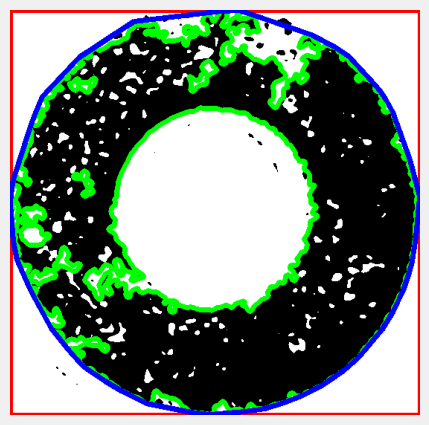

Inverting colors.
Number of filtered contours: 7


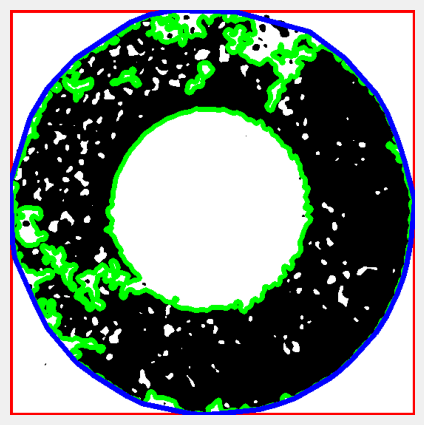

Inverting colors.
Number of filtered contours: 9


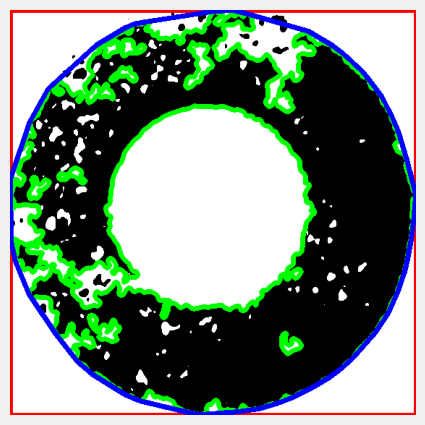

Inverting colors.
Number of filtered contours: 10


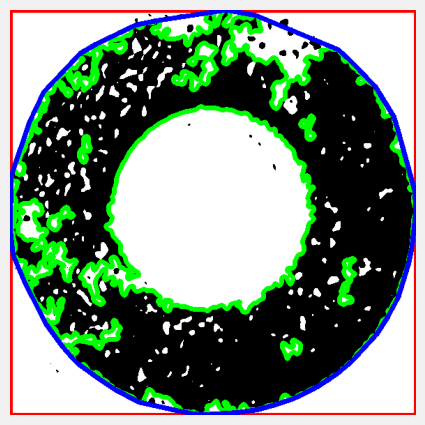

Inverting colors.
Number of filtered contours: 5


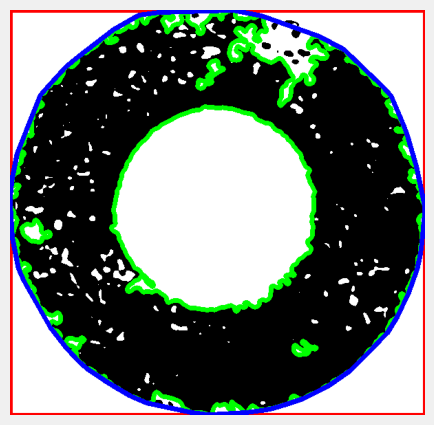

Number of filtered contours: 14


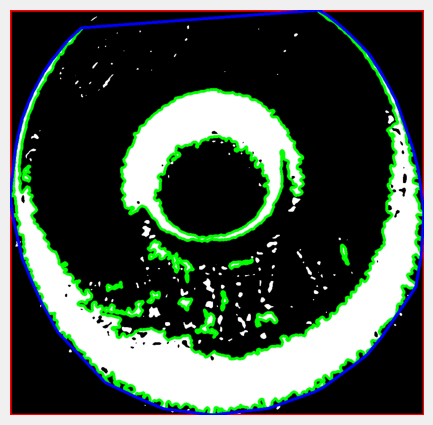

Number of filtered contours: 2


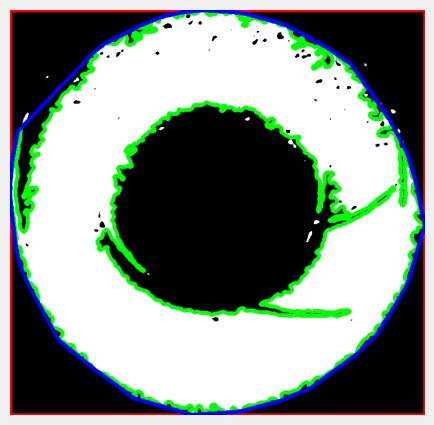

Processing label: tornillo
Number of filtered contours: 7


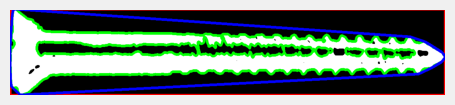

Number of filtered contours: 10


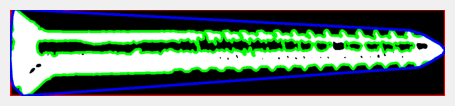

Number of filtered contours: 10


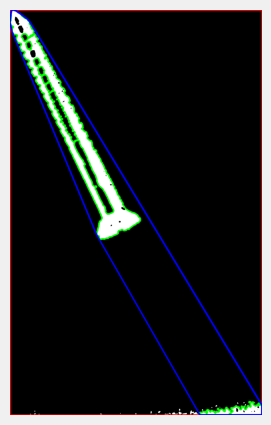

Number of filtered contours: 7


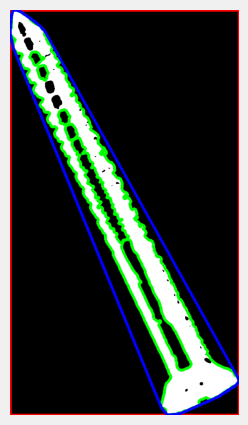

Number of filtered contours: 4


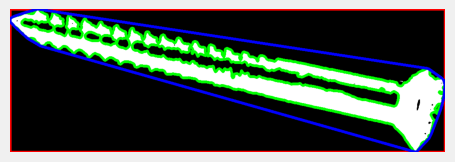

Processing label: tuerca
Number of filtered contours: 11


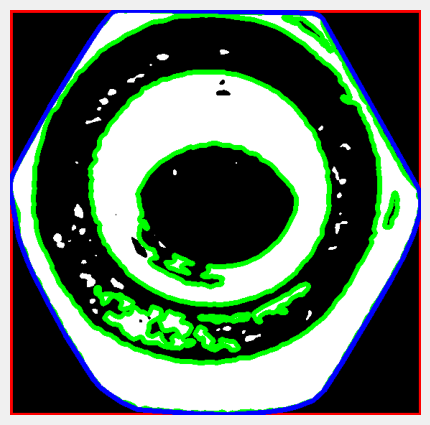

Number of filtered contours: 11


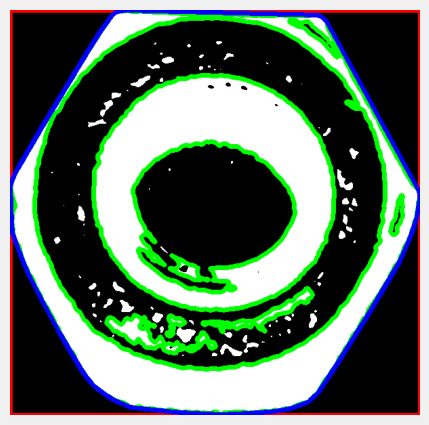

Number of filtered contours: 8


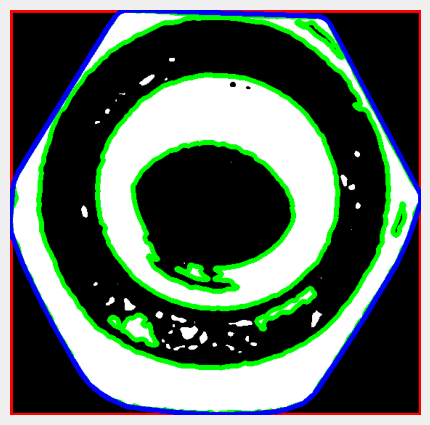

Number of filtered contours: 9


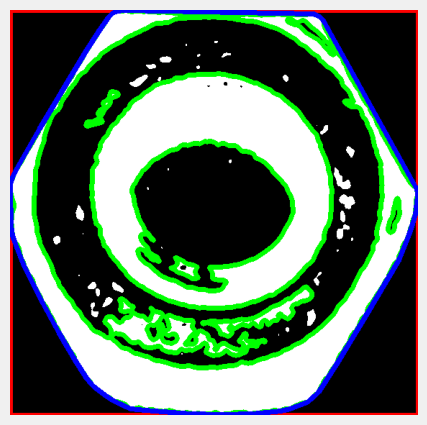

Processing label: clavo
Number of filtered contours: 1


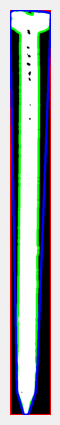

Number of filtered contours: 1


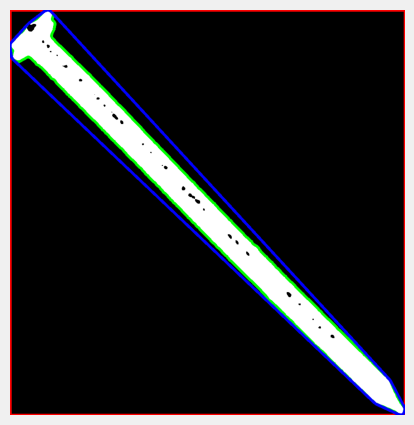

Number of filtered contours: 7


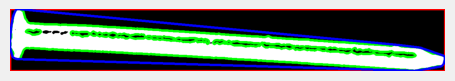

Number of filtered contours: 1


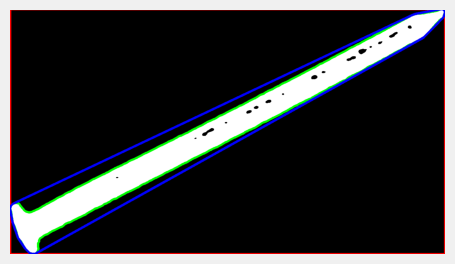

Number of filtered contours: 1


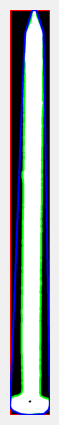

In [27]:
eps = 0.01
min_length = 100
cropped_dataset = {'arandela': [], 'tornillo': [], 'tuerca': [], 'clavo': []}
cropped_contours = []
hulls = []

for label, images in otsu_filtered_dataset.items():
        print(f"Processing label: {label}")
        for i, image in enumerate(images[:7]):
            # Step 1: Find and filter contours
            filtered_contours = find_and_filter_contours(image, min_length)
            print(f"Number of filtered contours: {len(filtered_contours)}")
            
            hull = convex_Hull(filtered_contours)

            # Step 4: Crop and adjust contours
            cropped_image, adjusted_contours, adjusted_hull = crop_and_adjust_contours(
                image, hull, filtered_contours)
            
            cropped_dataset[label].append(cropped_image)
            cropped_contours.append(adjusted_contours)
            hulls.append(adjusted_hull)

In [17]:
cropped_contours[0]

[array([[[307,   0]],
 
        [[306,   1]],
 
        [[306,   3]],
 
        ...,
 
        [[309,   4]],
 
        [[309,   1]],
 
        [[308,   0]]], shape=(1475, 1, 2))]

## Comparación de area del Convex Hull y la mínima circunferencia

Processing label: arandela
Circle Center: (273.6122131347656, 269.5978088378906), Radius: 277.0818176269531, Area: 241193.6826087989
Hull area: 233455.0
Area Ratio: 0.9679150692294435


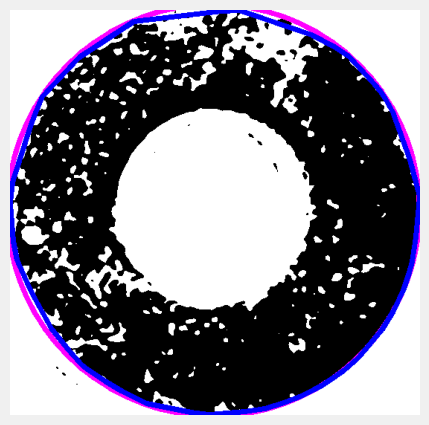

Circle Center: (272.7823486328125, 270.7068786621094), Radius: 277.95294189453125, Area: 242712.656003453
Hull area: 235335.0
Area Ratio: 0.9696033320843885


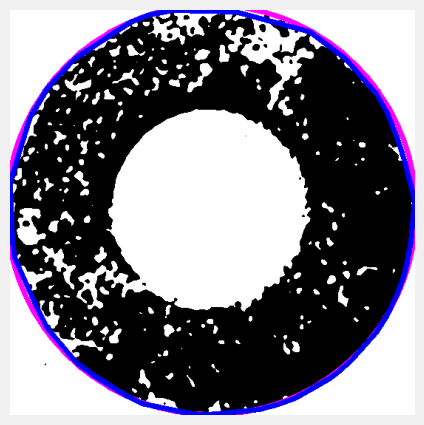

Circle Center: (279.30615234375, 276.92144775390625), Radius: 282.738525390625, Area: 251142.28998186844
Hull area: 244883.0
Area Ratio: 0.9750767185314734


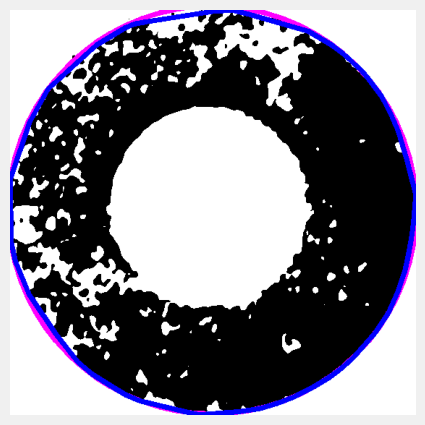

Circle Center: (288.45281982421875, 288.32330322265625), Radius: 295.24444580078125, Area: 273850.37838843407
Hull area: 264782.0
Area Ratio: 0.9668856459435987


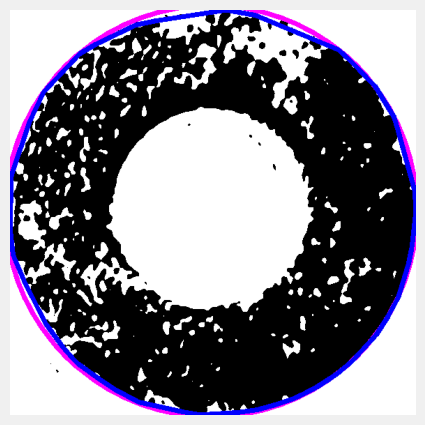

Circle Center: (299.1557312011719, 291.4031982421875), Radius: 305.71905517578125, Area: 293626.2577895762
Hull area: 279987.5
Area Ratio: 0.9535506194430668


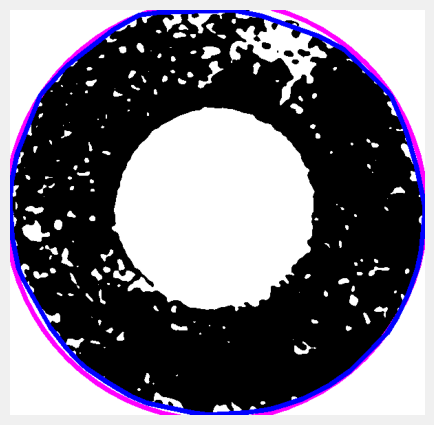

Circle Center: (492.5232849121094, 446.7134704589844), Radius: 517.9768676757812, Area: 842889.420318848
Hull area: 763488.5
Area Ratio: 0.9057991257159068


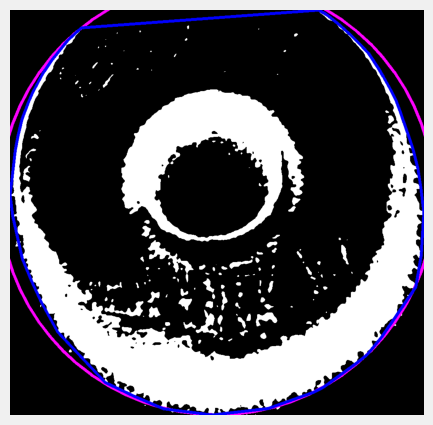

Circle Center: (351.7484130859375, 335.39111328125), Radius: 361.9102783203125, Area: 411482.8198526619
Hull area: 376330.5
Area Ratio: 0.9145715977516418


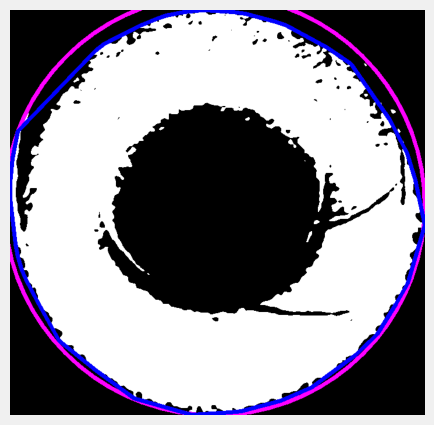

Processing label: tornillo
Circle Center: (568.81396484375, 115.00834655761719), Radius: 572.2918090820312, Area: 1028927.8748737221
Hull area: 175225.5
Area Ratio: 0.17029910869263312


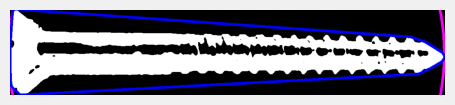

Circle Center: (570.27392578125, 105.71367645263672), Radius: 571.735595703125, Area: 1026928.8061171536
Hull area: 177250.0
Area Ratio: 0.17260203330957982


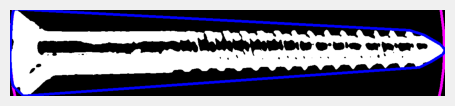

Circle Center: (526.0, 842.5), Radius: 988.153076171875, Area: 3067597.157143098
Hull area: 358008.0
Area Ratio: 0.1167063280021483


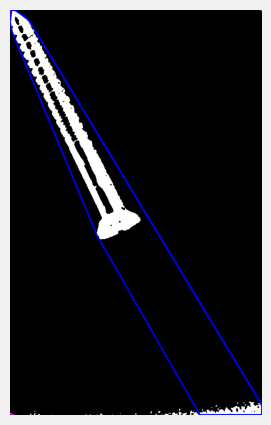

Circle Center: (237.99720764160156, 457.78326416015625), Radius: 511.86456298828125, Area: 823114.0225783106
Hull area: 135039.5
Area Ratio: 0.16405928740832795


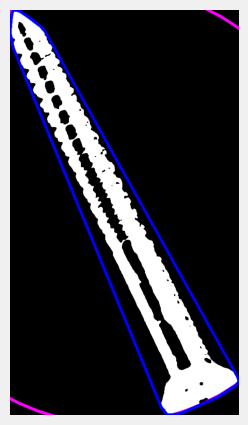

Circle Center: (538.0, 120.0), Radius: 546.3233032226562, Area: 937668.4941283277
Hull area: 155215.0
Area Ratio: 0.1655329159206639


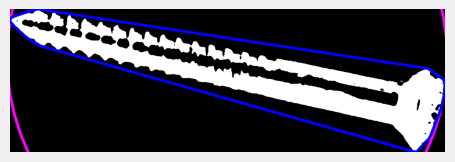

Processing label: tuerca
Circle Center: (282.0, 273.0), Radius: 304.1382141113281, Area: 290597.48784999707
Hull area: 246973.0
Area Ratio: 0.8498800241779257


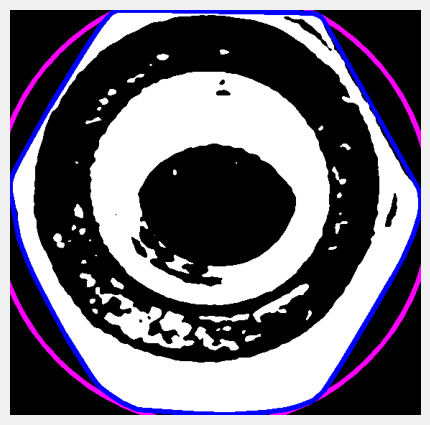

Circle Center: (301.4505920410156, 290.01995849609375), Radius: 321.79052734375, Area: 325309.22846794623
Hull area: 276825.0
Area Ratio: 0.8509595663907716


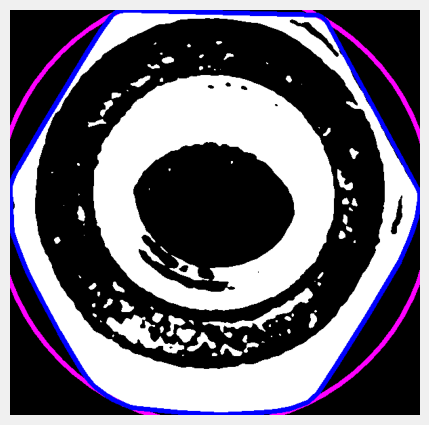

Circle Center: (283.120849609375, 272.4292907714844), Radius: 300.9783630371094, Area: 284590.51681540586
Hull area: 239985.0
Area Ratio: 0.8432642193613978


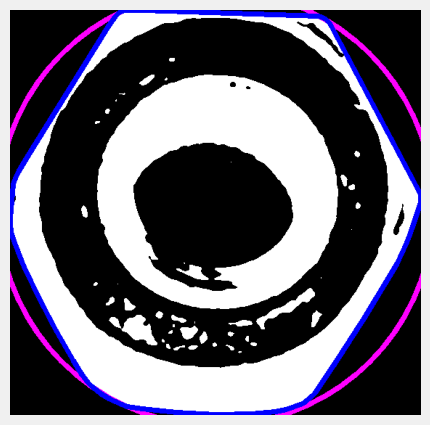

Circle Center: (281.36920166015625, 273.23321533203125), Radius: 303.1672058105469, Area: 288744.8950482985
Hull area: 245371.0
Area Ratio: 0.8497847207271202


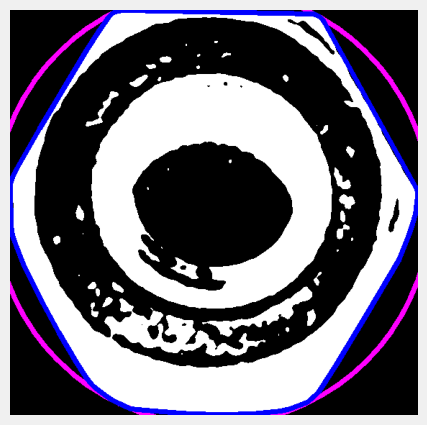

Processing label: clavo
Circle Center: (31.5, 611.0), Radius: 611.2801513671875, Area: 1173898.2660429846
Hull area: 105122.0
Area Ratio: 0.08954949763606751


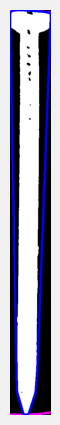

Circle Center: (486.0, 494.5), Radius: 640.4657592773438, Area: 1288669.9616042052
Hull area: 128919.5
Area Ratio: 0.10004074265804576


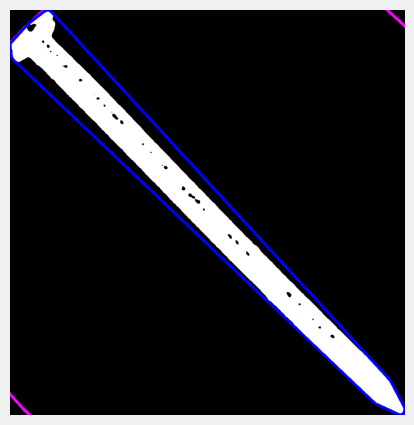

Circle Center: (633.5, 118.0), Radius: 634.16357421875, Area: 1263433.7050835195
Hull area: 131917.0
Area Ratio: 0.10441149343192456


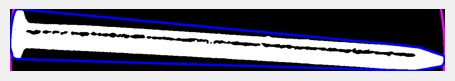

Circle Center: (657.0, 342.0), Radius: 717.1179809570312, Area: 1615589.7788074312
Hull area: 163328.0
Area Ratio: 0.10109496986330448


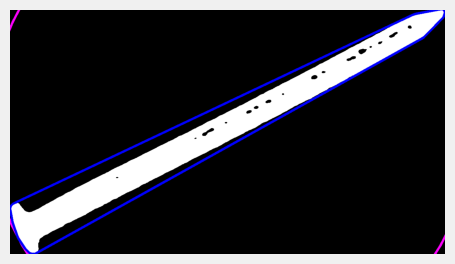

Circle Center: (73.5, 710.0), Radius: 710.148193359375, Area: 1584338.0253681398
Hull area: 140830.5
Area Ratio: 0.08888917500245969


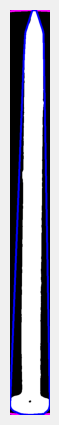

In [18]:
import math
count = 0
for label, images in cropped_dataset.items():
    print(f"Processing label: {label}")
    for i, image in enumerate(images[:7]):
        hull = hulls[count]
        count+=1
        (x, y), radius = cv2.minEnclosingCircle(hull)

        circle_area = math.pi * (radius ** 2)
        
        print(f"Circle Center: ({x}, {y}), Radius: {radius}, Area: {circle_area}")

        hull_area= cv2.contourArea(hull)
        print(f"Hull area: {hull_area}")
        print(f"Area Ratio: {hull_area/circle_area}")
        center = (int(x), int(y))
        radius = int(radius)

        image_with_circle = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.circle(image_with_circle, center, radius, (255, 0, 255), 5)
        cv2.drawContours(image_with_circle, [hull], -1, (255, 0, 0), 5)

        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(image_with_circle, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()